# GNN CODE 

Installs:

In [1]:
#!pip install torch
#!pip install torch_scatter
#!pip install torch_sparse
#!pip install torch_geometric
#!pip install sklearn
#!pip install networkx
#!pip install metaknowledge
#!pip install matplotlib

Imports:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import InMemoryDataset, Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import StandardScaler
import metaknowledge as mk
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Data Import Functions:

In [3]:
def network_import(file_txt):
    #lists to hold outputs
    networks = []
    masks = []
    
    #creates core, non-core and mixed networks from .txt files
    RC = mk.RecordCollection(file_txt)
    network1 = RC.networkCitation(nodeType='full',coreOnly=True)
    network1 = nx.Graph(network1)
    network1 = network1.to_undirected()
    c1 = list(network1.nodes)
    
    network2 = RC.networkCitation(nodeType='full',coreOnly=False)
    network2 = nx.Graph(network2)
    network2 = network2.to_undirected()

    network3 = nx.compose(network1,network2)
    
    #creates sub-graphs from mixed network
    sub_graphs = (network3.subgraph(c).copy() for c in nx.connected_components(network3))
    
    #loops for nodes in each subgraph
    for idx,g in enumerate(sub_graphs,start=1):
        
        #creates initial variables for an index list and mask
        index=[]
        mask = torch.zeros(g.number_of_nodes(), dtype=torch.bool)
        
        #only uses if sub-graphs above a size of 1000 nodes
        if len(g.nodes())>1000:
            c2 = list(g.nodes)
            #print(c2)
            
            #loops for mixed nodes
            for i in range(0,len(c2)):
                
                #loops for all core nodes
                for nodes2 in c1:
                    
                    #records index of core node in mixed network
                    if c2[i]==nodes2:
                        index.append(i)
                        
            #creates mask using index of core nodes
            mask[index] = True
            #adds network and mask to list
            networks.append(g)
            masks.append(mask)
    #outputs list of networks and masks
    return networks, masks

def panda_import(file_csv):
    #reads file as dataframe, drops duplicates and resets index as needed
    panda = pd.read_csv(file_csv)
    panda.drop_duplicates()
    panda.reset_index()
    return panda

Data Setup Function:

In [4]:
scaler = StandardScaler()
def data_setup(G,df):
    
    #creates edge index from network
    adj = nx.to_scipy_sparse_matrix(G).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    
    #creates labels from dataframe
    labels = ((df['FR'].to_numpy()).astype(np.compat.long))
    
    #scales imported centralities of nodes
    df[['DC','EC','LC','BC','CC']] = scaler.fit_transform(df[['DC','EC','LC','BC','CC']])

    #reformats dataframe as numpy array
    embeddings = ((df[['DC','EC','LC','BC','CC']]).to_numpy().astype(np.float64))

    #returns variables
    return labels,edge_index,embeddings,G

Dataset Class:

In [5]:
#defines custom data class
class GNNDataset(InMemoryDataset):
    def __init__(self, Mask, transform=None):
        super(GNNDataset, self).__init__('.', transform, None, None)

        # edge index
        data = Data(edge_index=edge_index)
        
        # number of nodes
        data.num_nodes = G.number_of_nodes()
        
        # embedding data
        data.x = torch.from_numpy(embeddings.copy()).type(torch.float32)
        
        data.num_features  = np.size(embeddings, 1)
        
        # labels
        y = torch.from_numpy(labels.copy()).type(torch.long)
        data.y = y.clone().detach()
        
        # core node mask
        data['mask'] = Mask
        
        # class data
        data.num_classes = 2

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

Creating Dataset:

In [6]:
#imports dataset
JOPCS, JOPCS_Masks = network_import("JOPCS_t.txt")
AMM, AMM_Masks = network_import("AMM_t.txt")
IJEEEE, IJEEEE_Masks = network_import("IJEEEE_t.txt")
JMS, JMS_Masks = network_import("JMS_t.txt") 

#ensures imports correctly due to multiple subgraphs in one dataset
c=0
if len(list(JOPCS[0].nodes))!= 4883:
    c=1
while c==1:
    #print(c,len(list(JOPCS[0].nodes)),len(list(JOPCS[1].nodes)))
    temp1 = JOPCS.copy()
    JOPCS[0]=temp1[1]
    JOPCS[1]=temp1[0]
    
    temp2 = JOPCS_Masks.copy()
    JOPCS_Masks[0]=temp2[1]
    JOPCS_Masks[1]=temp2[0]
    
    if len(list(JOPCS[0].nodes)) == 4883:
        c=0

#creates and orders dataset variable
JOPCS1 = panda_import('JOPCS_Cent_1.csv')
JOPCS1.ND = JOPCS1.ND.astype("category")
JOPCS1.ND.cat.set_categories([' Filler1']+list(JOPCS[0].nodes), inplace=True)
#print(JOPCS1['ND']) 
JOPCS1 = JOPCS1.sort_values(["ND"], ignore_index=True)
#print(JOPCS1['ND'])
JOPCS1.reset_index()

#creates and orders dataset variable
JOPCS2 = panda_import('JOPCS_Cent_2.csv')
JOPCS2.ND = JOPCS2.ND.astype("category")
JOPCS2.ND.cat.set_categories([' Filler2']+list(JOPCS[1].nodes), inplace=True)
#print(JOPCS2['ND'])
JOPCS2 = JOPCS2.sort_values(["ND"], ignore_index=True)
#print(JOPCS2['ND'])
JOPCS2.reset_index()

#creates and orders dataset variable
AMM1 = panda_import('AMM_Cent_1.csv')
AMM1.ND = AMM1.ND.astype("category")
AMM1.ND.cat.set_categories([' Filler3']+list(AMM[0].nodes), inplace=True)
#print(AMM1['ND'])
AMM1 = AMM1.sort_values(["ND"], ignore_index=True)
#print(AMM1['ND'])
AMM1.reset_index()

#creates and orders dataset variable
IJEEEE1 = panda_import('IJEEEE_Cent_1.csv')
IJEEEE1.ND = IJEEEE1.ND.astype("category")
IJEEEE1.ND.cat.set_categories([' Filler4']+list(IJEEEE[0].nodes), inplace=True)
#print(IJEEEE1['ND'])
IJEEEE1 = IJEEEE1.sort_values(["ND"], ignore_index=True)
#print(IJEEEE1['ND'])
IJEEEE1.reset_index()

#creates and orders dataset variable
JMS1 = panda_import('JMS_Cent_1.csv')
JMS1.ND = JMS1.ND.astype("category")
JMS1.ND.cat.set_categories([' Filler5']+list(JMS[0].nodes), inplace=True)
#print(JMS1['ND'])
JMS1 = JMS1.sort_values(["ND"], ignore_index=True)
#print(JMS1['ND'])axis=0,ignore_index=Tru
JMS1.reset_index()

#merges masks
Mask = torch.cat((JOPCS_Masks[0],JOPCS_Masks[1],AMM_Masks[0],IJEEEE_Masks[0],JMS_Masks[0]))

#merges datasets
Node_Data = pd.concat([JOPCS1,JOPCS2,AMM1,IJEEEE1,JMS1],axis=0,ignore_index=True)

#merges networks
G = nx.disjoint_union(JOPCS[0],JOPCS[1])
G = nx.disjoint_union(G,AMM[0])
G = nx.disjoint_union(G,IJEEEE[0])
G = nx.disjoint_union(G,JMS[0])

#sets up data and creates custom dataset
labels,edge_index,embeddings,G = data_setup(G,Node_Data)
Dataset = GNNDataset(Mask)


Resampling Data:

In [7]:
#splits data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(pd.Series(list(G.nodes())), pd.Series(labels), test_size=0.30, random_state=42)

#oversamples cases of fraud
X = pd.concat([X_train, Y_train], axis=1)

#splits fraud and non-fraud index
not_fraud = X[X[1]==0]
fraud = X[X[1]==1]
n = 1500

#resamples index as needed
fraud_upsampled = resample(fraud,replace=True, n_samples= n , random_state=42) 

#merges indexes
X_up = pd.concat([not_fraud, fraud_upsampled])

#changes used variables to over sampled ones
X_train = X_up[0].copy()
Y_train = X_up[1].copy()

Training Model:

Baseline: ROC AUC=0.500
GNN Model: ROC AUC=0.540


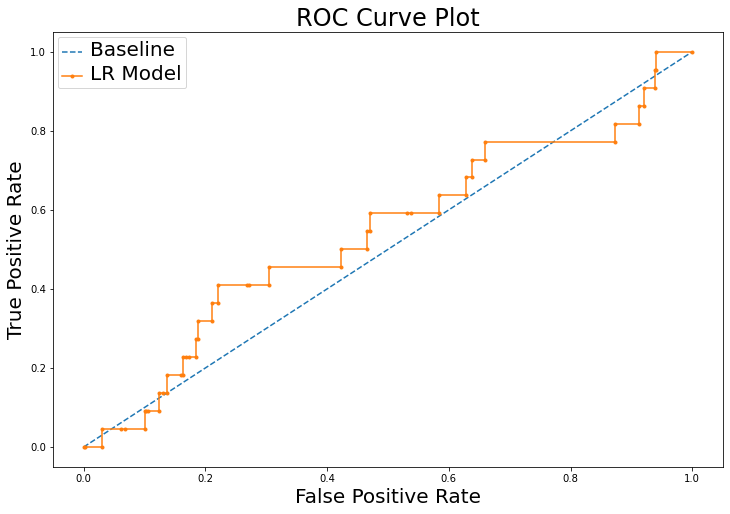

In [9]:
from sklearn import linear_model

#defines model
regr = linear_model.LinearRegression()

#defines data used
XTR = pd.DataFrame(Dataset[0].x[torch.tensor(list(X_train))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_train)))]].numpy())
YTR = pd.DataFrame(Dataset[0].y[torch.tensor(list(X_train))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_train)))]].numpy())
XTS = pd.DataFrame(Dataset[0].x[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]].numpy())
YTS = pd.DataFrame(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]].numpy())

#trains model
regr.fit(XTR,YTR)

#tests model
pred = regr.predict(XTS)

ns_probs = [0 for _ in range(0,len(pred))]
test = YTS

# calculate AUC ROC scores
ns_auc = roc_auc_score(test, ns_probs)
lr_auc = roc_auc_score(test, pred)

# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('GNN Model: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test, pred)

# plot the roc curve for the model
plt.figure(figsize=(12,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LR Model')

# axis labels
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve Plot', fontsize=24)

# show the legend
legend = plt.legend()
plt.setp(legend.get_title(),fontsize=20)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')

# show the plot and saves outputs
plt.show()